- title: Занятие 14
- author: Vitalii Zavadskyi
- date: 2025-12-05
- slug: 2025_lpr_lab14
- lecture_link: lectures/2025_lpr_lec14.html
- lecture_comment: Лекция 14
- ipynb_url: download/2025_lpr_lab14.ipynb

# Лабораторное занятие 14

 В этой лабораторной работе мы познакомимся с деревьями решений из scikit-learn: `DecisionTreeClassifier`, `DecisionTreeRegressor`, `RandomForestClassifier`, `RandomForestRegressor`.

## Дерево решений

Пускай есть набор точек $X$, которые описываются двумя признаками $x_0$ и $x_1$. Точки могут принадлежать классу 0 или классу 1 (метка $y_i$). Пускай наш классфикатор очень простой и на любой объект у него один ответ - 1. Тогда вероятность ошибиться равна 
$$ F_1(X) = \dfrac{1}{|X|}\sum\limits_i [y_i \neq 1]. $$
В этой абстрактной задаче мы хотим подобрать некоторые значения $x_0^{\prime}$ и $x_1^{\prime}$ (для соответствующих признаков) так, что они разделят наше множество точек $X$ самым удачным образом. Как определить меру удачности?

Попробуем привести следующее рассуждение: наше правило будет столь близко к идеальному, насколько близко к нулю будет вероятность ошибки. Попробуем искусственно собрать функцию для минимизации:
$$Q(X) = \dfrac{|X_l|}{|X|} F_1(X_l) + \dfrac{|X_r|}{|X|} F_0(X_r),$$
где $X_l/X_r$ левое/правое подмножество. Первая часть соответствует ошибке правильного определения класса 1 на левом подмножестве (куда мы отправляли всех 1), вторая часть соотвествует ошибке определения класса 0 на правом подмножестве (куда мы отправили все 0). Для взвешенного голосования приписываются веса ошибкам в соотвествии с долями множеств. Если в левое подмножество попало много объектов из исходного, то его ошибка должна быть весомее. Альтернативное определение для функции максимизации:
$$\widetilde{Q}(x) = F_1(X) - \dfrac{|X_l|}{|X|} F_1(X_l) - \dfrac{|X_r|}{|X|} F_0(X_r).$$
Функцию $\widetilde{Q}$ уже нужно максимизировать.

Вместо $F_1/F_0$ предпочитают использовать функции, которые симметрично учитывали бы влияние 0го и 1го классов. Такие функции:
- Критерий Джини:
$$G(X) = \sum\limits_i p_i (1 - p_i).$$
- Энтропия Шенона:
$$H(X) = -\sum\limits_i p_i \log(p_i).$$

Теперь практика.

### Дерево решений своими руками

Возьмем стандартный набор данных о пингвинах и сведем задачу определения трех классов пингвинов к одному.

In [1]:
from seaborn import load_dataset

df = load_dataset("penguins")

df.loc[df["species"] == "Adelie", "species"] = "Another"
df.loc[df["species"] == "Chinstrap", "species"] = "Another"

df.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Another  Torgersen            39.1           18.7              181.0   
1  Another  Torgersen            39.5           17.4              186.0   
2  Another  Torgersen            40.3           18.0              195.0   
3  Another  Torgersen             NaN            NaN                NaN   
4  Another  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

В данных есть пропуски в признаках. Уберем такие строки.

In [2]:
print(f"Shape before dropna: {df.shape}")
df.dropna(inplace=True)
print(f"Shape after dropna: {df.shape}")

df.head()

Shape before dropna: (344, 7)
Shape after dropna: (333, 7)


species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Another  Torgersen            39.1           18.7              181.0   
1  Another  Torgersen            39.5           17.4              186.0   
2  Another  Torgersen            40.3           18.0              195.0   
4  Another  Torgersen            36.7           19.3              193.0   
5  Another  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
4       3450.0  Female  
5       3650.0    Male

В данных присутствуют категориальные признаки.

**Упражнение 1.** Преобразуйте категориальные признаки в численные.

In [ ]:
from sklearn.preprocessing import LabelEncoder

for column in ["species", "island", "sex"]:
    # Ваш код

df.head()

species  island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0        0       2            39.1           18.7              181.0   
1        0       2            39.5           17.4              186.0   
2        0       2            40.3           18.0              195.0   
4        0       2            36.7           19.3              193.0   
5        0       2            39.3           20.6              190.0   

   body_mass_g  sex  
0       3750.0    1  
1       3800.0    0  
2       3250.0    0  
4       3450.0    0  
5       3650.0    1

Нарисуем совместное распределение признаков.

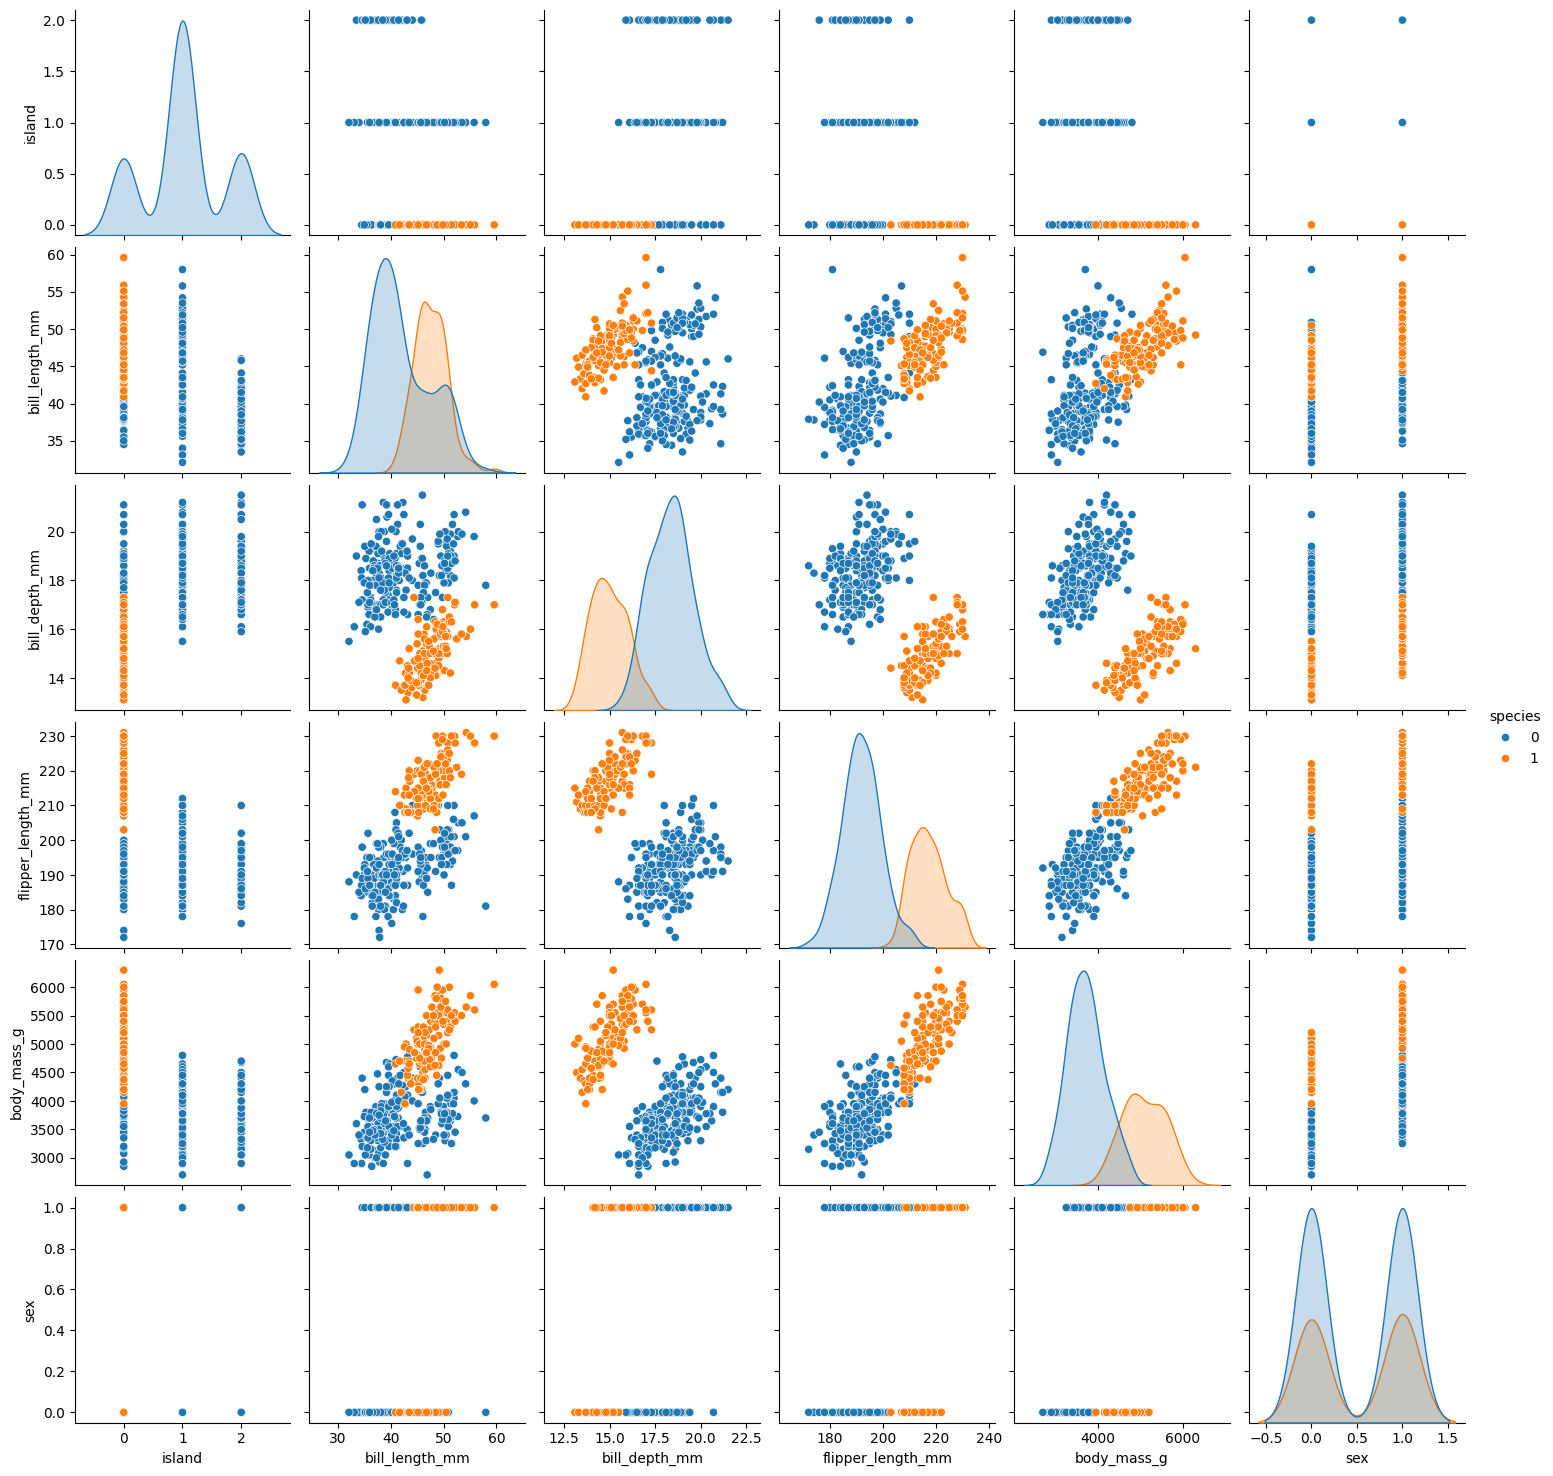

In [4]:
from seaborn import pairplot

pairplot(df, hue="species");

Для простоты задачи рассмотрим только два признака: `bill_depth_mm` и `body_mass_g`. Выделим два этих признака и разделяем выборку на обучающую и тестовую.

In [5]:
from sklearn.model_selection import train_test_split

feature_names = ["bill_depth_mm", "body_mass_g"]
target_name = "species"

X = df[feature_names].to_numpy()
y = df[target_name].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

**Упражнение 2**. Нарисуйте тестовую выборку синим и обучающую оранжевым. Форма точки должна отображать принадлежность к одному из классов.

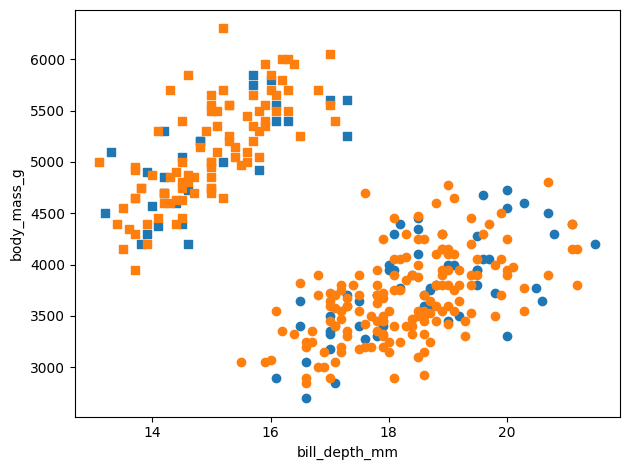

In [ ]:
from matplotlib import pyplot as plt

mask = y_test == 1
plt.scatter(
plt.scatter(

mask = y_train == 1
plt.scatter(
plt.scatter(
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.tight_layout()

Попробуем разделить объекты по признаку `body_nass_g`. Для этого найдем все уникальные значения данного признака, отсортируем эти значения и пройдемся по средним точкам для определения значения функции $Q(X)$ с использованием самого простого критерия $F$.

In [7]:
def F(y_actual, y_pred):
    if len(y_actual):
        return sum(y_actual != y_pred) / len(y_actual)
    return 0.0

def Q(X_l, X_r):
    l_len = X_l.shape[0]
    r_len = X_r.shape[0]
    X_len = l_len + r_len
    return F(X_l, 1) * l_len / X_len + F(X_r, 0) * r_len / X_len

In [8]:
import numpy as np
import pandas as pd

feature_name = feature_names[0]
feature = X_train[:, 0]

unique_values = np.sort(np.unique(feature))

decision_values = (unique_values[1:] + unique_values[:-1]) / 2.0

result0 = []
for decision_value in decision_values:
    mask = feature < decision_value
    X_l = y_train[mask]
    X_r = y_train[~mask]
    result0.append({"decision value": decision_value, "Q": Q(X_l, X_r)})

result0 = pd.DataFrame(result0)
result0.head()

decision value         Q
0           13.25  0.361446
1           13.45  0.357430
2           13.55  0.349398
3           13.65  0.345382
4           13.75  0.321285

**Упражнение 3**: нарисуйте полученную выше зависимость.

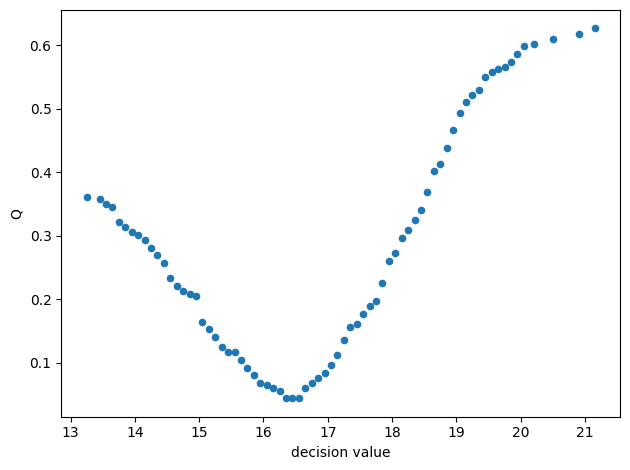

In [ ]:
from matplotlib import pyplot as plt


Найдем точку минимума.

In [10]:
row0 = result0.iloc[result0["Q"].idxmin()]
feature0_best = row0["decision value"]
row0

decision value    16.550000
Q                  0.044177
Name: 32, dtype: float64

Нарисуем полученный критерий.

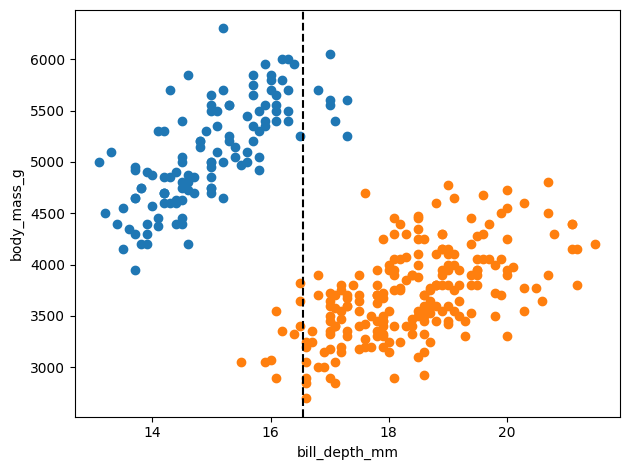

In [11]:
from matplotlib import pyplot as plt

mask = y == 1
plt.scatter(X[mask, 0], X[mask, 1], color="C0")
plt.scatter(X[~mask, 0], X[~mask, 1], color="C1")
plt.axvline(feature0_best, linestyle="--", color="black")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.tight_layout()

**Упражнение 4**: повторите несколько предыдущих пунктов, но уже с использованием `body_mass_g`. Найдите для данного признака наилучшее разбиение.

**Примечание**: учтите изменение направленности классов относительно разделяющей прямой.

   decision value         Q
0          2875.0  0.630522
1          2912.5  0.618474
2          2962.5  0.614458
3          3025.0  0.606426
4          3062.5  0.594378
decision value    4325.000000
Q                    0.060241
Name: 44, dtype: float64


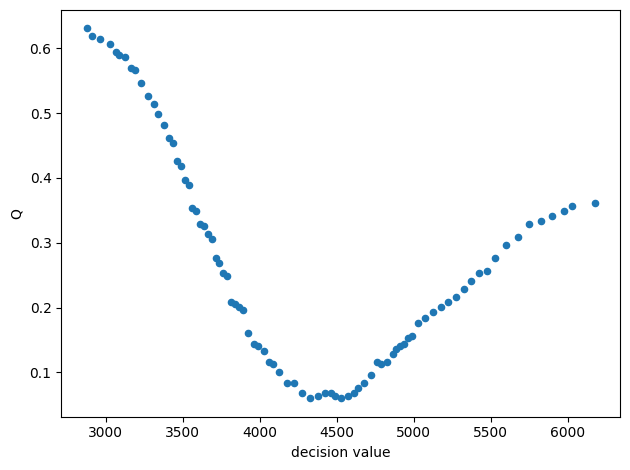

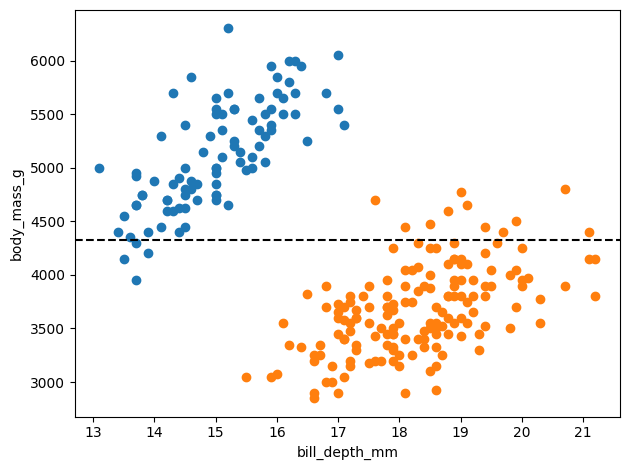

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


feature = 

unique_values = 

decision_values = 

result1 = []
for decision_value in decision_values:
    # Ваш код

result1 = pd.DataFrame(result1)
print(result1.head())

result1.plot.scatter(x="decision value", y="Q")
plt.tight_layout()

row1 = result1.iloc[result1["Q"].idxmin()]
feature1_best = row1["decision value"]
print(row1)

mask = y_train == 1
plt.figure()
plt.scatter(X_train[mask, 0], X_train[mask, 1], color="C0")
plt.scatter(X_train[~mask, 0], X_train[~mask, 1], color="C1")
plt.axhline(feature1_best, linestyle="--", color="black")
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.tight_layout()

Как определить какое из разделений лучше соответствует разделению изначального множество. Поступим **жадным** образом. Выберем разбиение с меньшей ошибкой. Это как раз таки первое разбиение.

Что же делать дальше? Ответ один -- пытаться разделить полученные подмножества. На рисунке хорошо видно, что выделяются две вертикальные прямые в левой нижней и верхней правой частях, которые отлично разделят плоскость.

**Упражнение 5**: попробуйте на глаз или же с использованием критерия выше определить нужные прямые для разделения.

decision value    14.7
Q                  1.0
Name: 2, dtype: float64
decision value    17.35
Q                  1.00
Name: 35, dtype: float64


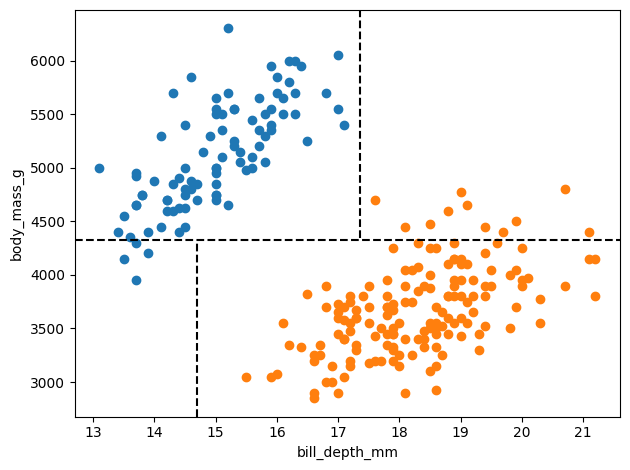

In [ ]:
import numpy as np
import pandas as pd

mask = X_train[:, 1] < feature1_best
X0_l = X_train[mask, 0]
X0_r = X_train[~mask, 0]
y0_l = y_train[mask]
y0_r = y_train[~mask]


features0_best = []
for X, y in [(X0_l, y0_l), (X0_r, y0_r)]:
    unique_values = np.sort(np.unique(X))
    decision_values = (unique_values[1:] + unique_values[:-1]) / 2.0
    result = []
    for decision_value in decision_values:
        mask_inner = X > decision_value
        # Ваш код

Получили отличное разделение классов. Теперь же попробуем освоить эту технику с использованием уже готового класса `DecisionTreeClassifier`.

### sklearn реализация

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1, splitter="best", max_depth=2)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

Отрисуем дерево. Это можно сделать двумя путями:

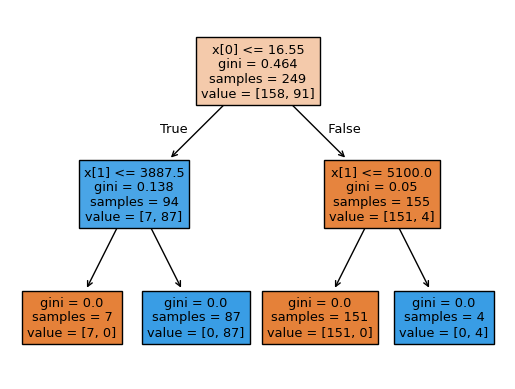

In [15]:
from sklearn.tree import plot_tree

plot_tree(tree, filled=True);

Альтернативный вариант -- на плоскости вместе с объектами.

Tree Accuracy: 1.00


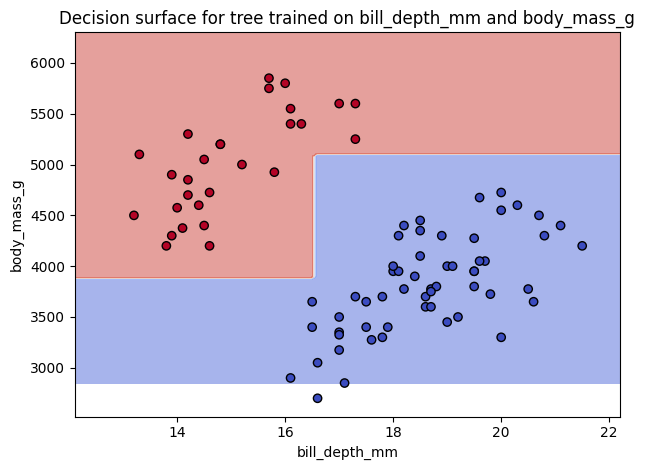

In [16]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

disp = DecisionBoundaryDisplay.from_estimator(
    tree,
    X_train,
    response_method="predict",
    xlabel=feature_names[0],
    ylabel=feature_names[1],
    alpha=0.5, 
    cmap=plt.cm.coolwarm
)

accuracy_tree = accuracy_score(y_test, tree.predict(X_test))
print(f'Tree Accuracy: {accuracy_tree:.2f}')

disp.ax_.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    edgecolor="k",
    cmap=plt.cm.coolwarm
)

plt.title(f"Decision surface for tree trained on {feature_names[0]} and {feature_names[1]}")
plt.tight_layout()

Модель в sklearn пошла другим путем. Она решила изначально разделить объекты вертикальной прямой, а только потом добавлять горизонтальные.

**Упражнение 6**: попробуйте альетрнативное разделение, начиная с вертикальной прямой. Получится ли у вас результат модели из sklearn?

Важно отметить еще одну особенность. Модель выше использует критерий Джини для оценки разделяющего критерия. Этот факт может повлиять на обучение.

Попробуем создать достаточно глубокое дерево.

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1, splitter="random", max_depth=10)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=1, splitter='random')

Tree Accuracy: 0.98


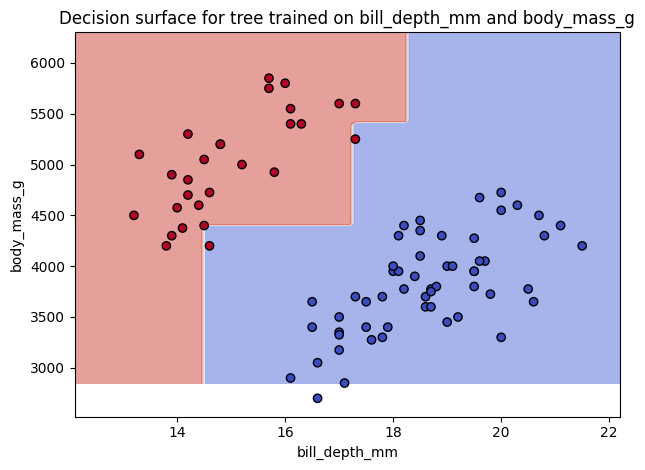

In [18]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

disp = DecisionBoundaryDisplay.from_estimator(
    tree,
    X_train,
    response_method="predict",
    xlabel=feature_names[0],
    ylabel=feature_names[1],
    alpha=0.5, 
    cmap=plt.cm.coolwarm
)

accuracy_tree = accuracy_score(y_test, tree.predict(X_test))
print(f'Tree Accuracy: {accuracy_tree:.2f}')

disp.ax_.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    edgecolor="k",
    cmap=plt.cm.coolwarm
)

plt.title(f"Decision surface for tree trained on {feature_names[0]} and {feature_names[1]}")
plt.tight_layout()

В текущем использовании алгоритма мы заменили параметр `splitter` с `best` на `random`. Это определяет правило выбора признака для разделения выборки на два класса. Если выше мы выбирали **жадным** образом, то введение случайности позволило незначительно углубить дерево. По количеству изломов мы видим, что максимальная глубина дерева не превышает 6 (как мы смогли это определить из картинки выше?).  

Сильно глубокое дерево ялвяется переобученным. Стараются глубину дерева держать в пределах 3-4.

Попробуем продемонстрировать переобученность на примере задачи регрессии.

### Задача регресии

В задаче регрессии дерево старается приблизить зависимость кусочно-постоянной функцией. Создадим учебный набор данных для демонстрации работы регрессии на основе деревьев.

In [19]:
from sklearn.datasets import make_regression

X, y = make_regression(
    n_features=3,
    random_state=12,
)

Изобразим данные в одном из разрезов.

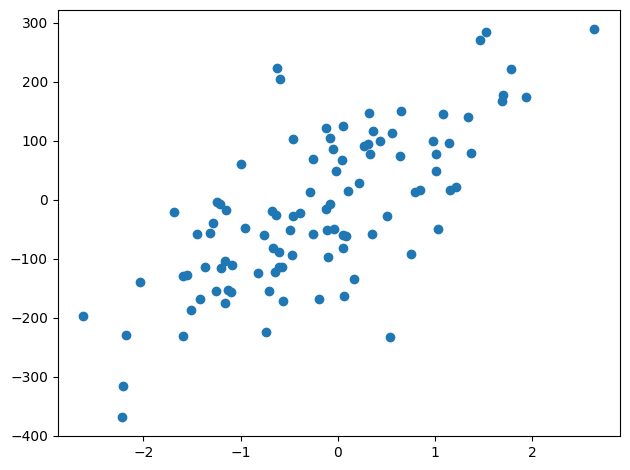

In [20]:
from matplotlib import pyplot as plt

plt.scatter(X[:, 2], y)
plt.tight_layout()

Попробуем обучить несколько деревьев разной глубины.

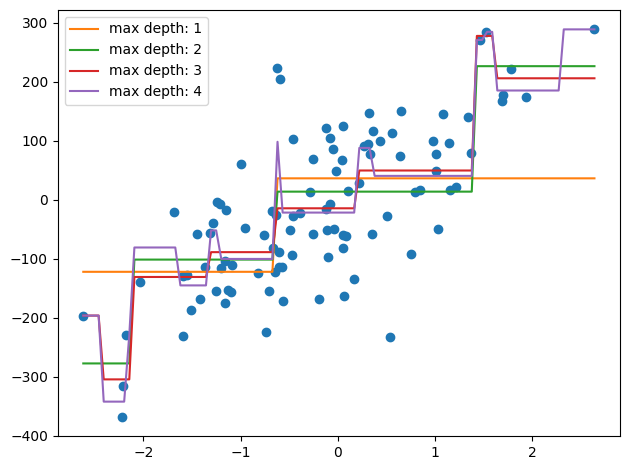

In [21]:
from sklearn.tree import DecisionTreeRegressor

X_test = np.linspace(
    X[:, 2].min(),
    X[:, 2].max(),
    101,
)

plt.scatter(X[:, 2], y)
for max_depth in range(1, 5):
    tree = DecisionTreeRegressor(random_state=1, splitter="best", max_depth=max_depth)
    tree.fit(X[:, 2].reshape((-1, 1)), y)

    plt.plot(X_test, tree.predict(X_test.reshape(-1, 1)), color=f"C{max_depth}", label=f"max depth: {max_depth}")
plt.legend()
plt.tight_layout()

**Упражнение 7**: создайте еще более глубокие деревья с глубиной от 6 до 10, как это повлияет на предсказание?

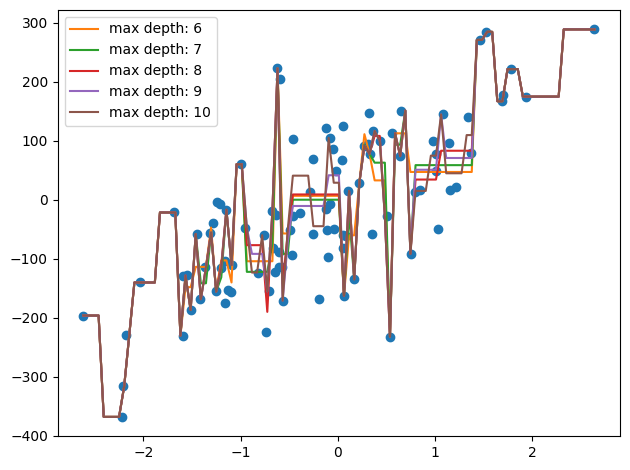

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X_test = np.linspace(
    X[:, 2].min(),
    X[:, 2].max(),
    101,
)

plt.scatter(X[:, 2], y)
for max_depth in range(6, 11):
    tree = 
    tree.

    plt.plot(
plt.legend()
plt.tight_layout()

Обсудим подход объединения деревьев. Если не справляется одно дерево, то справится целый лес.

## Случайный лес деревьев решений

В этом подходе предполагается, что мы можем взять $N$ штук деревьев, каждое дерево обучить на специфичной подвыборке, а потом методом голосования определять принадлежность к определенному классу/значение целевого показателя.

Продемонстрируем создания "леса".

In [23]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=10, max_depth=3)

forest.fit(X[:, 2].reshape((-1, 1)), y)

RandomForestRegressor(max_depth=3, n_estimators=10)

Попробуем сравнить предсказание для дерева и леса.

(6374.175318320366, 6814.24299152182)

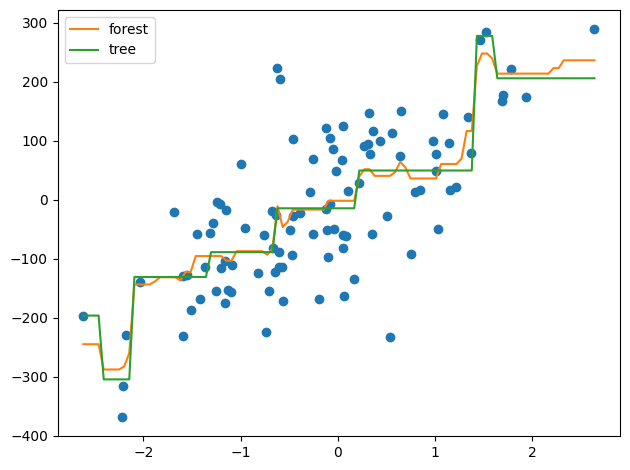

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree = DecisionTreeRegressor(random_state=1, splitter="best", max_depth=3)
tree.fit(X[:, 2].reshape((-1, 1)), y)

X_test = np.linspace(
    X[:, 2].min(),
    X[:, 2].max(),
    101,
)

plt.scatter(X[:, 2], y)
plt.plot(X_test, forest.predict(X_test.reshape(-1, 1)), color="C1", label="forest")
plt.plot(X_test, tree.predict(X_test.reshape(-1, 1)), color="C2", label="tree")
plt.legend()
plt.tight_layout()

mean_squared_error(y, forest.predict(X[:, 2].reshape(-1, 1))), mean_squared_error(y, tree.predict(X[:, 2].reshape(-1, 1)))

Лес деревьев дает более близкое предсказание к данным, а сама модель демонстрирует большое количество "скачков" -- указание на голосование между деревьями леса.

**Упражнение 9**: увеличьте количество деревьев до 100. Сравние результат подгонки с предыдущим лесом и одиночным деревом. Максимальная глубина дерева должна быть 3.

(6852.948313398212, 6395.6464761928455, 6814.24299152182)

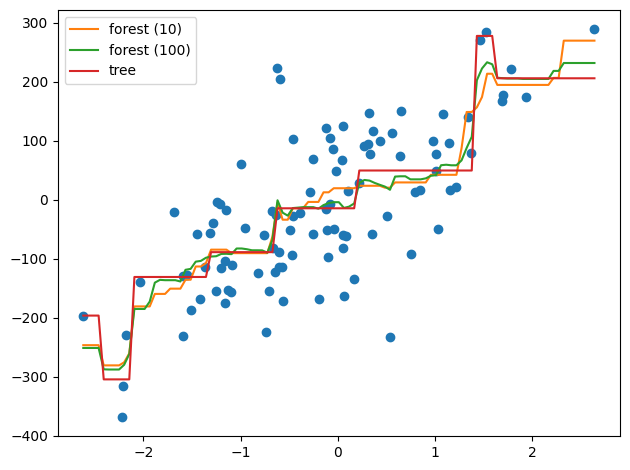

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

forest0 = 
forest0.

forest1 = 
forest1.

tree = 
tree.

X_test = np.linspace(
    X[:, 2].min(),
    X[:, 2].max(),
    101,
)

plt.scatter(X[:, 2], y)
plt.plot(X_test, forest0.predict(X_test.reshape(-1, 1)), color="C1", label="forest (10)")
plt.plot(X_test, forest1.predict(X_test.reshape(-1, 1)), color="C2", label="forest (100)")
plt.plot(X_test, tree.predict(X_test.reshape(-1, 1)), color="C3", label="tree")
plt.legend()
plt.tight_layout()

mean_squared_error(y, forest0.predict(X[:, 2].reshape(-1, 1))), mean_squared_error(y, forest1.predict(X[:, 2].reshape(-1, 1))), mean_squared_error(y, tree.predict(X[:, 2].reshape(-1, 1)))

## Практические задания

**Задание 1**: воспользуйтесь искусственным набором данных. Попробуйте обучить несколько моделей:
- Выделите только два признака: с индексами 0 и 1;
- Разделите данные на тренировочные и тестовые с использованием параметра `random_state=1`, все остальные параметры должны быть по умолчанию;
- Обучите дерево на основе двух признаков;
  - Попробуйте определить глубину дерева при которой начинается явное переобучение алгоритма:
    - Постройте значение `accuracy_score` от глубины дерева для тренировочной и тестовой выборок;
    - Найдите момент начала роста `accuracy_score`.
- Обучите лес деревьев на основе двух признаков. Для создания леса используйте `n_estimators=10`, остальные параметры должны быть по умолчанию;
  - Попробуйте определить глубину дерева при которой начинается явное переобучение алгоритма:
    - Постройте значение `accuracy_score` от глубины дерева для тренировочной и тестовой выборок;
    - Найдите момент начала роста `accuracy_score`.
- Продемонстрируйте разделение плосокости алгоритмам дерева решений на две области: выживших и нет;
- Продемонстрируйте разделение плосокости одним из деревом решений леса на две области: выживших и нет. Для получения определенного дерева требуется обратиться к следущему полю: `forest.estimators_[idx]`, где `idx` указывает на номер дерева в лесу.

**Спойлер**: решение задачи с использованием дерева решений на двух указаных признаках является не лучшим подходом. Здесь хорошо бы подошла логистическая регрессия или какой-нибудь другой алгоритм. Задача дается в демонстрационных целях.

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

from sklearn.datasets import make_classification

X, y = make_classification(n_samples=400, n_classes=2, n_features=4, random_state=15)

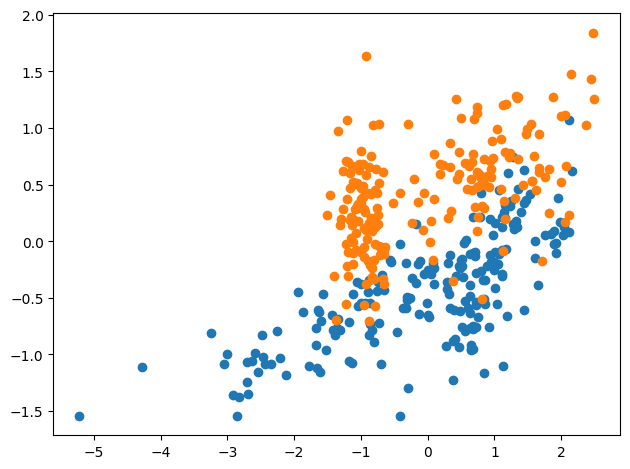

In [28]:
mask = y == 1
plt.scatter(X[mask, 0], X[mask, 1])
plt.scatter(X[~mask, 0], X[~mask, 1])
plt.tight_layout()

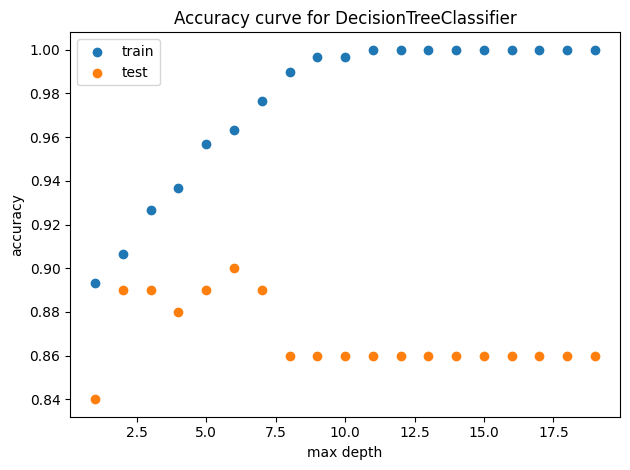

In [ ]:
accuracy_scores_test = []
accuracy_scores_train = []
for max_depth in range(1, 20):
    tree = 
    tree.
    y_pred = 
    y_pred_train = tree.predict(X_train)
    accuracy_scores_test.append(accuracy_score(y_test, y_pred))
    accuracy_scores_train.append(accuracy_score(y_train, y_pred_train))

plt.scatter(range(1, 20), accuracy_scores_train, label="train")
plt.scatter(range(1, 20), accuracy_scores_test, label="test")
plt.title("Accuracy curve for DecisionTreeClassifier")
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()

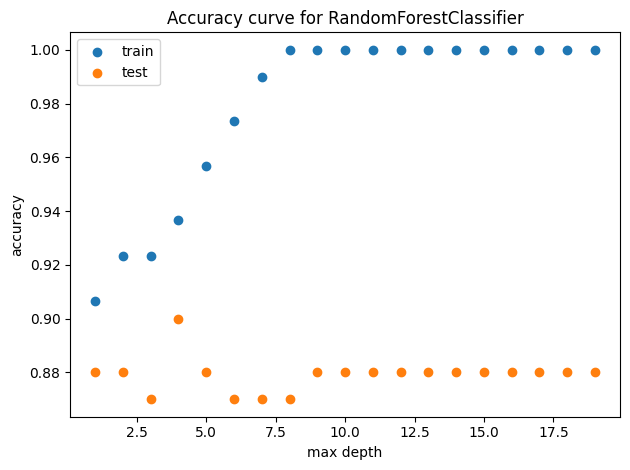

In [ ]:
accuracy_scores_test = []
accuracy_scores_train = []
for max_depth in range(1, 20):
    forest =
    forest. 
    y_pred = 
    y_pred_train = forest.predict(X_train)
    accuracy_scores_test.append(accuracy_score(y_test, y_pred))
    accuracy_scores_train.append(accuracy_score(y_train, y_pred_train))

plt.scatter(range(1, 20), accuracy_scores_train, label="train")
plt.scatter(range(1, 20), accuracy_scores_test, label="test")
plt.title("Accuracy curve for RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.legend()
plt.tight_layout()

**Задание 2**: проанализируйте набор данных Титаник с использованием четырех признаков: пол, класс каюты, возраст и место посадки.
- Определите лучшую глубину дерева решений;
- Определите лучшую глубину леса деревьев решений.

**Задание 3**: оцените цену диамантов по их характеристикам с использованием моделей `DecisionTreeRegressor` и `RandomForestRegrossor`.
- Определите лучшую глубину дерева решений;
- Определите лучшую глубину леса деревьев решений.

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from seaborn import load_dataset

df = load_dataset("diamonds")

df.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75